# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Add, Activation, Concatenate
from tensorflow.keras.callbacks import History, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate, LeakyReLU, Reshape, Conv2DTranspose, Flatten, Conv2D
from tensorflow.keras.models import Model,Sequential

from utils import *

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

physical_devices = tf.config.experimental.list_physical_devices()
print("All available physical devices:", physical_devices)

# Select a GPU device for training
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    device = gpu_devices[0]
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(device, 'GPU')
    print("Selected GPU device:", device)
else:
    print("No GPU devices found.")
    

All available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Selected GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load training and test data

In [3]:
outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")

print(outerdata_test.shape)

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)

print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
print('shape of cond_data: ', cond_data.shape)

(378876, 8)
shape of data_train:  (499889, 6)
shape of data_test:  (378759, 6)
shape of data:  (878648, 6)
shape of cond_train (499889,)
shape of cond_test (378759,)
shape of cond_data:  (878648,)


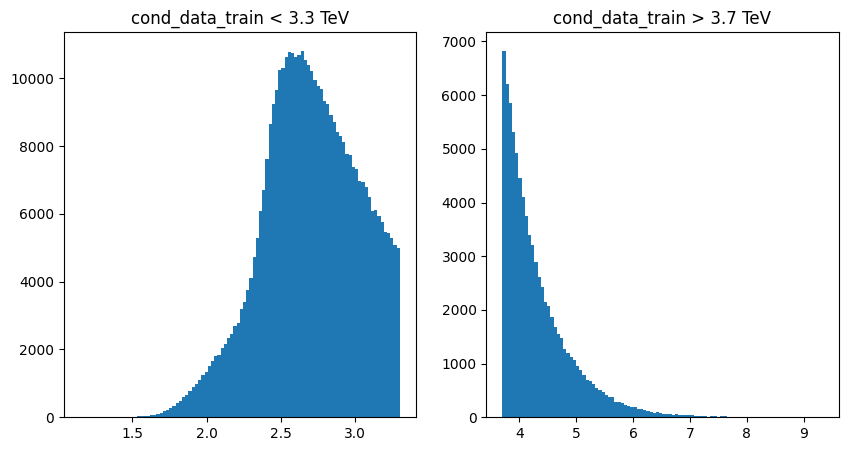

total event count in lower region:  417822
total event count in upper region:  82067


In [4]:
# conditional data has two region one from 0 to 3.3 and one from 3.7 to 1 
# plot these two regions separately
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(cond_data_train[cond_data_train<3.3], bins=100)
plt.title('cond_data_train < 3.3 TeV')
plt.subplot(1,2,2)
plt.hist(cond_data_train[cond_data_train>3.7], bins=100)
plt.title('cond_data_train > 3.7 TeV')
plt.show()

#we also want to show the total event count in each region
print('total event count in lower region: ', len(cond_data_train[cond_data_train<3.3]))
print('total event count in upper region: ', len(cond_data_train[cond_data_train>3.7]))


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [5]:
feature_names = {
                0: "$m_{2}$",
                1: "$\Delta m = m_{1} - m_{2}$ ",
                2: "$\\tau_{21}^{J1}$",
                3: "$\\tau_{21}^{J2}$",
                4: "$\\tau_{32}^{J1}$",
                5: "$\\tau_{32}^{J2}$"
    
}

In [6]:
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}

In [7]:
def plot_variables(data, density = False):
    
    plt.figure(figsize=(12,12))
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    
    
    for i in range(input_dim):
        plt.subplot((input_dim+1)//2, 2, i+1)
        plt.xlabel(feature_names[i])
        plt.hist(data[:, i], bins=30, color = "darkblue",  histtype = "step", label = feature_labels[i], density = density)
        plt.legend()
        plt.yscale('log')


/tmp/ipykernel_35749/709068183.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot((input_dim+1)//2, 2, i+1)


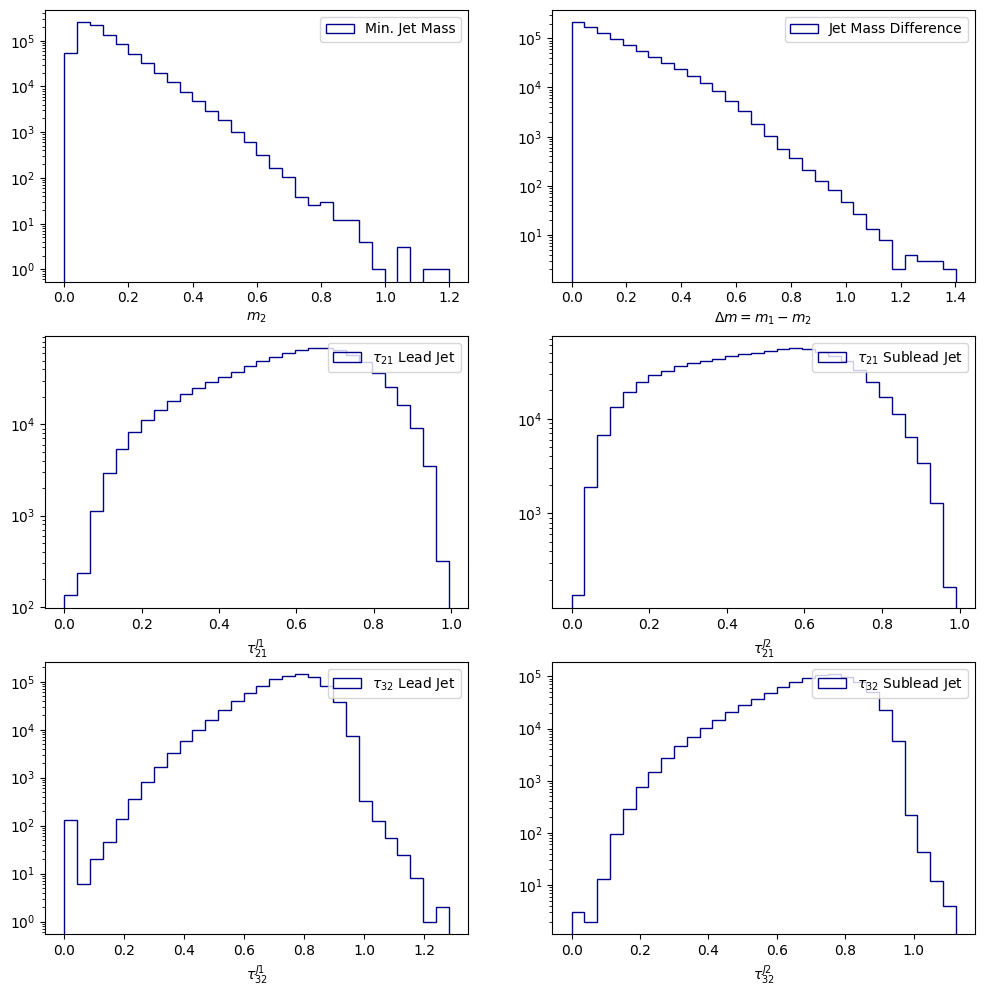

In [8]:
plot_variables(data)

### Feature scaling
<!-- Dividing each feature by the `abs(maximum)` value -->

In [8]:
# feature_max = np.empty(nFeat)

# for i in range(0,data.shape[1]):
#     feature_max[i] = np.max(np.abs(data[:,i]))
#     if np.abs(feature_max[i]) > 0: 
#         data[:,i] = data[:,i]/feature_max[i]
#     else:
#         pass

# cond_max = np.max(np.abs(cond_data))

# if np.abs(cond_max) > 0:
#     cond_data = cond_data/cond_max
# else:
#     pass

#nin-max normalization
print(data.shape)
data, data_max, data_min = minmax_norm_data(data)
cond_data, cond_data_max, cond_data_min  = minmax_norm_cond_data(cond_data)

print(data.shape)


(878648, 6)
(878648, 6)


## Setting up for training

### Defining the train and test sets

In [9]:
trainsize = outerdata_train.shape[0]

print(data.shape)
data = data[:,0:input_dim]
data = np.reshape(data, (len(cond_data),input_dim))
print("Data Shape: ", np.shape(data))
x_train = data[:trainsize]
print(x_train.shape)
x_test = data[trainsize:]
y_train = cond_data[:trainsize]
y_test = cond_data[trainsize:]

# x_train = np.hstack([x_train,y_train.reshape(y_train.shape[0],1)])
# x_test = np.hstack([x_test,y_test.reshape(y_test.shape[0],1)])

image_size = x_train.shape[1]
original_dim = image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

(878648, 6)
Data Shape:  (878648, 6)
(499889, 6)


### Train cGAN

In [15]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [12]:
# CGAN3
def create_conditional_generator():

    generator = Sequential()
    # explicit input dimensions
    generator.add(Dense(units=512,input_dim=nFeat+1,name="Gen_Dense1"))# one more variable!
    generator.add(LeakyReLU(0.2,name="Gen_LR1"))
    generator.add(BatchNormalization(momentum=0.8)) #new
    
    generator.add(Dense(units=256,name="Gen_Dense2"))
    generator.add(LeakyReLU(0.2,name="Gen_LR2"))
    generator.add(BatchNormalization(momentum=0.8)) #new

    generator.add(Dense(units=128,name="Gen_Dense3"))
    generator.add(LeakyReLU(0.2,name="Gen_LR3"))
    generator.add(BatchNormalization(momentum=0.8)) #new
    
    generator.add(Dense(units=56,name="Gen_Dense4"))
    generator.add(LeakyReLU(0.2,name="Gen_LR4"))
    generator.add(BatchNormalization(momentum=0.8)) #new
    
    generator.add(Dense(units=nFeat,name="Gen_LR5"))#, activation='tanh'))
    
    #y = Input(shape=(1,))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
cg=create_conditional_generator()
cg.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_Dense1 (Dense)           (None, 512)               4096      
_________________________________________________________________
Gen_LR1 (LeakyReLU)          (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
Gen_Dense2 (Dense)           (None, 256)               131328    
_________________________________________________________________
Gen_LR2 (LeakyReLU)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________

In [13]:
def create_conditional_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=nFeat+1,name="Disc_Dense1")) #new; was 1024
    discriminator.add(LeakyReLU(0.2,name="Disc_LR1"))
    discriminator.add(Dropout(0.1,name="Disc_Drop1")) # new: removed
       
    discriminator.add(Dense(units=512,name="Disc_Dense2")) #new; was 512
    discriminator.add(LeakyReLU(0.2,name="Disc_LR2"))
    discriminator.add(Dropout(0.1,name="Disc_Drop2")) #new: removed
       
    discriminator.add(Dense(units=256,name="Disc_Dense3")) #new: removed, was 256
    discriminator.add(LeakyReLU(0.2,name="Disc_LR3")) #new: removed
    discriminator.add(Dropout(0.1,name="Disc_Drop3")) #new
    
    discriminator.add(Dense(units=128,name="Disc_Dense4")) #new: removed, was 256
    discriminator.add(LeakyReLU(0.2,name="Disc_LR4")) #new: removed
    discriminator.add(Dropout(0.1,name="Disc_Drop4")) #new
    
    discriminator.add(Dense(units=1, activation='sigmoid',name="Disc_SigmoidOut"))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
cd = create_conditional_discriminator()
cd.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Disc_Dense1 (Dense)          (None, 1024)              8192      
_________________________________________________________________
Disc_LR1 (LeakyReLU)         (None, 1024)              0         
_________________________________________________________________
Disc_Drop1 (Dropout)         (None, 1024)              0         
_________________________________________________________________
Disc_Dense2 (Dense)          (None, 512)               524800    
_________________________________________________________________
Disc_LR2 (LeakyReLU)         (None, 512)               0         
_________________________________________________________________
Disc_Drop2 (Dropout)         (None, 512)               0         
__________________________

In [14]:
def create_conditional_gan(discriminator, generator):
    discriminator.trainable=False    
    # now this
    gan_input = Input(shape=(nFeat,),name="GAN_NoiseInput")
    y = Input(shape=(1,),name="GAN_condY")
    x = generator(Concatenate(axis=-1)([gan_input,y]))
    gan_output = discriminator(Concatenate(axis=-1)([x,y]))
    gan = Model(inputs=[y,gan_input], outputs=gan_output,name="GAN")
    gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer())#optimizer='adam') #new
    return gan
cgan = create_conditional_gan(cd,cg)
cgan.summary()

Model: "GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_NoiseInput (InputLayer)     [(None, 6)]          0                                            
__________________________________________________________________________________________________
GAN_condY (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7)            0           GAN_NoiseInput[0][0]             
                                                                 GAN_condY[0][0]                  
__________________________________________________________________________________________________
sequential (Sequential)         (None, 6)            179694      concatenate[0][0]              

In [15]:
from tensorflow.keras.models import save_model

def conditional_training(X, y, epochs=1, batch_size=128):
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train = X
    y_train = y
        
    batch_count = int(X_train.shape[0] / batch_size)

    # Standardizing???
    #from sklearn import preprocessing
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)

    # Creating GAN
    generator= create_conditional_generator()
    discriminator= create_conditional_discriminator()
    gan = create_conditional_gan(discriminator, generator)
    
    d_hist_r, d_hist_f, g_hist  = list(), list(), list()
    half_batch = int(batch_size / 2)
    
    for e in range(epochs):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_count)):
            # --------------------
            # Train discriminator
            # --------------------

            idx = np.random.randint(0, X_train.shape[0], half_batch)
            y_real = y_train[idx]
            x_real = np.hstack([X_train[idx],y_train[idx].reshape(half_batch,1)])
        
            noise = np.random.normal(0, 1, (half_batch, nFeat))
            #noise = np.random.uniform(0, 1, (half_batch, nFeat))
            cond_noise = np.hstack([noise,y_real.reshape(half_batch,1)])
            x_fake = generator.predict(cond_noise)
            x_fake = np.hstack([x_fake,y_real.reshape(half_batch,1)])
        
            discriminator.trainable=True #added
            d_loss_real = discriminator.train_on_batch(x_real, 0.9*np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(x_fake, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # --------------------
            # Train generator
            # --------------------
            discriminator.trainable=False #added
            noise = np.random.normal(0, 1, (batch_size, nFeat)) #label the generated samples as 1
            #noise = np.random.uniform(0, 1, (batch_size, nFeat)) #label the generated samples as 1
            new_idx = np.random.randint(0, y_train.shape[0], batch_size)
            g_loss = gan.train_on_batch([y_train[new_idx],noise], np.ones((batch_size,1)))

            # --------------------
            # Save losses
            # --------------------
            d_hist_r.append(d_loss_real) 
            d_hist_f.append(d_loss_fake) 
            g_hist.append(g_loss)

        if e == 0 or e % 50 == 0:
            list_of_cgen_models.append(generator)
            
            discriminator.trainable = False
            save_model(gan, "gan_models/gan_%d.h5"%e)
            discriminator.trainable = True
            save_model(generator, "gan_models/gen_%d.h5"%e)
            save_model(discriminator, "gan_models/disc%d.h5"%e)
    
            # generator.save("tmp_%d.h5"%e) 
    return d_hist_r, d_hist_f, g_hist

In [16]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


2023-03-23 10:50:07.392693: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2023-03-23 10:50:07.434124: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1996255000 Hz
2023-03-23 10:50:07.446653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d77650f330 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-23 10:50:07.446676: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-03-23 10:50:07.447893: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-23 10:50:07.488294: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-23 10:50:07.488319: I tensorflow/stream_executor/cuda/cuda_d

In [ ]:
X = x_train
y = y_train
list_of_cgen_models = []
cd1_hist_r, cd1_hist_f, cg_hist = conditional_training(X,y,301,256)

Epoch 0


  0%|          | 0/1952 [00:00<?, ?it/s]

100%|██████████| 1952/1952 [01:19<00:00, 24.42it/s]


Epoch 1


100%|██████████| 1952/1952 [01:17<00:00, 25.25it/s]


Epoch 2


100%|██████████| 1952/1952 [01:17<00:00, 25.25it/s]


Epoch 3


100%|██████████| 1952/1952 [01:16<00:00, 25.49it/s]


Epoch 4


100%|██████████| 1952/1952 [01:17<00:00, 25.31it/s]


Epoch 5


100%|██████████| 1952/1952 [01:16<00:00, 25.39it/s]


Epoch 6


100%|██████████| 1952/1952 [01:17<00:00, 25.27it/s]


Epoch 7


100%|██████████| 1952/1952 [01:17<00:00, 25.33it/s]


Epoch 8


100%|██████████| 1952/1952 [01:17<00:00, 25.20it/s]


Epoch 9


100%|██████████| 1952/1952 [01:16<00:00, 25.38it/s]


Epoch 10


100%|██████████| 1952/1952 [01:17<00:00, 25.32it/s]


Epoch 11


100%|██████████| 1952/1952 [01:17<00:00, 25.30it/s]


Epoch 12


100%|██████████| 1952/1952 [01:17<00:00, 25.35it/s]


Epoch 13


100%|██████████| 1952/1952 [01:16<00:00, 25.40it/s]


Epoch 14


100%|██████████| 1952/1952 [01:16<00:00, 25.47it/s]


Epoch 15


100%|██████████| 1952/1952 [01:16<00:00, 25.52it/s]


Epoch 16


100%|██████████| 1952/1952 [01:16<00:00, 25.49it/s]


Epoch 17


100%|██████████| 1952/1952 [01:16<00:00, 25.44it/s]


Epoch 18


100%|██████████| 1952/1952 [01:16<00:00, 25.43it/s]


Epoch 19


100%|██████████| 1952/1952 [01:16<00:00, 25.38it/s]


Epoch 20


100%|██████████| 1952/1952 [01:16<00:00, 25.54it/s]


Epoch 21


100%|██████████| 1952/1952 [01:16<00:00, 25.56it/s]


Epoch 22


100%|██████████| 1952/1952 [01:16<00:00, 25.45it/s]


Epoch 23


100%|██████████| 1952/1952 [01:17<00:00, 25.35it/s]


Epoch 24


100%|██████████| 1952/1952 [01:17<00:00, 25.29it/s]


Epoch 25


100%|██████████| 1952/1952 [01:15<00:00, 25.78it/s]


Epoch 26


100%|██████████| 1952/1952 [01:16<00:00, 25.52it/s]


Epoch 27


100%|██████████| 1952/1952 [01:16<00:00, 25.37it/s]


Epoch 28


100%|██████████| 1952/1952 [01:17<00:00, 25.21it/s]


Epoch 29


100%|██████████| 1952/1952 [01:16<00:00, 25.58it/s]


Epoch 30


100%|██████████| 1952/1952 [01:16<00:00, 25.50it/s]


Epoch 31


100%|██████████| 1952/1952 [01:16<00:00, 25.52it/s]


Epoch 32


100%|██████████| 1952/1952 [01:16<00:00, 25.52it/s]


Epoch 33


100%|██████████| 1952/1952 [01:16<00:00, 25.46it/s]


Epoch 34


100%|██████████| 1952/1952 [01:17<00:00, 25.26it/s]


Epoch 35


100%|██████████| 1952/1952 [01:16<00:00, 25.47it/s]


Epoch 36


100%|██████████| 1952/1952 [01:16<00:00, 25.39it/s]


Epoch 37


100%|██████████| 1952/1952 [01:17<00:00, 25.29it/s]


Epoch 38


100%|██████████| 1952/1952 [01:16<00:00, 25.40it/s]


Epoch 39


100%|██████████| 1952/1952 [01:18<00:00, 24.81it/s]


Epoch 40


100%|██████████| 1952/1952 [01:18<00:00, 24.92it/s]


Epoch 41


100%|██████████| 1952/1952 [01:18<00:00, 24.99it/s]


Epoch 42


100%|██████████| 1952/1952 [01:18<00:00, 25.02it/s]


Epoch 43


100%|██████████| 1952/1952 [01:18<00:00, 24.95it/s]


Epoch 44


100%|██████████| 1952/1952 [01:18<00:00, 24.95it/s]


Epoch 45


100%|██████████| 1952/1952 [01:18<00:00, 24.93it/s]


Epoch 46


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 47


100%|██████████| 1952/1952 [01:18<00:00, 24.98it/s]


Epoch 48


100%|██████████| 1952/1952 [01:17<00:00, 25.12it/s]


Epoch 49


100%|██████████| 1952/1952 [01:18<00:00, 24.99it/s]


Epoch 50


100%|██████████| 1952/1952 [01:17<00:00, 25.14it/s]


Epoch 51


100%|██████████| 1952/1952 [01:17<00:00, 25.05it/s]


Epoch 52


100%|██████████| 1952/1952 [01:18<00:00, 24.99it/s]


Epoch 53


100%|██████████| 1952/1952 [01:17<00:00, 25.12it/s]


Epoch 54


100%|██████████| 1952/1952 [01:18<00:00, 24.79it/s]


Epoch 55


100%|██████████| 1952/1952 [01:19<00:00, 24.47it/s]


Epoch 56


100%|██████████| 1952/1952 [01:19<00:00, 24.49it/s]


Epoch 57


100%|██████████| 1952/1952 [01:19<00:00, 24.55it/s]


Epoch 58


100%|██████████| 1952/1952 [01:19<00:00, 24.47it/s]


Epoch 59


100%|██████████| 1952/1952 [01:20<00:00, 24.32it/s]


Epoch 60


100%|██████████| 1952/1952 [01:19<00:00, 24.60it/s]


Epoch 61


100%|██████████| 1952/1952 [01:19<00:00, 24.57it/s]


Epoch 62


100%|██████████| 1952/1952 [01:18<00:00, 24.79it/s]


Epoch 63


100%|██████████| 1952/1952 [01:18<00:00, 24.96it/s]


Epoch 64


100%|██████████| 1952/1952 [01:18<00:00, 24.87it/s]


Epoch 65


100%|██████████| 1952/1952 [01:18<00:00, 24.97it/s]


Epoch 66


100%|██████████| 1952/1952 [01:18<00:00, 24.96it/s]


Epoch 67


100%|██████████| 1952/1952 [01:18<00:00, 24.94it/s]


Epoch 70


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 71


100%|██████████| 1952/1952 [01:17<00:00, 25.06it/s]


Epoch 72


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 73


 63%|██████▎   | 1233/1952 [00:49<00:28, 25.21it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:18<00:00, 24.98it/s]


Epoch 91


100%|██████████| 1952/1952 [01:18<00:00, 24.99it/s]


Epoch 92


100%|██████████| 1952/1952 [01:18<00:00, 24.86it/s]


Epoch 93


100%|██████████| 1952/1952 [01:18<00:00, 24.96it/s]


Epoch 94


100%|██████████| 1952/1952 [01:18<00:00, 24.96it/s]


Epoch 95


 10%|▉         | 195/1952 [00:07<01:10, 24.98it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:18<00:00, 24.98it/s]


Epoch 113


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 114


100%|██████████| 1952/1952 [01:17<00:00, 25.09it/s]


Epoch 115


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 116


 75%|███████▍  | 1458/1952 [00:58<00:19, 24.80it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:18<00:00, 24.95it/s]


Epoch 135


100%|██████████| 1952/1952 [01:18<00:00, 24.93it/s]


Epoch 136


100%|██████████| 1952/1952 [01:18<00:00, 24.73it/s]


Epoch 137


100%|██████████| 1952/1952 [01:17<00:00, 25.06it/s]


Epoch 138


 75%|███████▌  | 1464/1952 [00:58<00:19, 25.09it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:19<00:00, 24.47it/s]


Epoch 156


100%|██████████| 1952/1952 [01:19<00:00, 24.52it/s]


Epoch 157


100%|██████████| 1952/1952 [01:19<00:00, 24.62it/s]


Epoch 158


100%|██████████| 1952/1952 [01:18<00:00, 24.75it/s]


Epoch 159


100%|██████████| 1952/1952 [01:19<00:00, 24.53it/s]


Epoch 160


 42%|████▏     | 825/1952 [00:33<00:45, 24.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:18<00:00, 24.95it/s]


Epoch 174


100%|██████████| 1952/1952 [01:18<00:00, 24.84it/s]


Epoch 175


100%|██████████| 1952/1952 [01:19<00:00, 24.65it/s]


Epoch 176


100%|██████████| 1952/1952 [01:18<00:00, 24.82it/s]


Epoch 177


100%|██████████| 1952/1952 [01:18<00:00, 24.86it/s]


Epoch 178


100%|██████████| 1952/1952 [01:18<00:00, 24.84it/s]


Epoch 179


100%|██████████| 1952/1952 [01:18<00:00, 24.83it/s]


Epoch 180


100%|██████████| 1952/1952 [01:18<00:00, 24.94it/s]


Epoch 181


100%|██████████| 1952/1952 [01:18<00:00, 24.98it/s]


Epoch 182


100%|██████████| 1952/1952 [01:18<00:00, 25.02it/s]


Epoch 183


100%|██████████| 1952/1952 [01:17<00:00, 25.09it/s]


Epoch 184


100%|██████████| 1952/1952 [01:18<00:00, 25.00it/s]


Epoch 185


100%|██████████| 1952/1952 [01:17<00:00, 25.06it/s]


Epoch 186


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 187


100%|██████████| 1952/1952 [01:17<00:00, 25.11it/s]


Epoch 188


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 189


100%|██████████| 1952/1952 [01:18<00:00, 24.96it/s]


Epoch 190


100%|██████████| 1952/1952 [01:18<00:00, 25.00it/s]


Epoch 191


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 192


100%|██████████| 1952/1952 [01:17<00:00, 25.07it/s]


Epoch 193


100%|██████████| 1952/1952 [01:17<00:00, 25.14it/s]


Epoch 194


100%|██████████| 1952/1952 [01:17<00:00, 25.14it/s]


Epoch 195


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 196


100%|██████████| 1952/1952 [01:17<00:00, 25.14it/s]


Epoch 197


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 198


100%|██████████| 1952/1952 [01:17<00:00, 25.06it/s]


Epoch 199


100%|██████████| 1952/1952 [01:17<00:00, 25.06it/s]


Epoch 200


100%|██████████| 1952/1952 [01:17<00:00, 25.04it/s]


Epoch 201


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 202


100%|██████████| 1952/1952 [01:17<00:00, 25.11it/s]


Epoch 203


100%|██████████| 1952/1952 [01:17<00:00, 25.15it/s]


Epoch 204


100%|██████████| 1952/1952 [01:17<00:00, 25.13it/s]


Epoch 205


100%|██████████| 1952/1952 [01:17<00:00, 25.13it/s]


Epoch 206


100%|██████████| 1952/1952 [01:17<00:00, 25.04it/s]


Epoch 207


100%|██████████| 1952/1952 [01:18<00:00, 24.98it/s]


Epoch 208


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 209


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 210


100%|██████████| 1952/1952 [01:17<00:00, 25.08it/s]


Epoch 211


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 212


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 213


100%|██████████| 1952/1952 [01:17<00:00, 25.12it/s]


Epoch 214


100%|██████████| 1952/1952 [01:17<00:00, 25.07it/s]


Epoch 215


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 216


100%|██████████| 1952/1952 [01:17<00:00, 25.05it/s]


Epoch 217


100%|██████████| 1952/1952 [01:17<00:00, 25.05it/s]


Epoch 218


100%|██████████| 1952/1952 [01:17<00:00, 25.12it/s]


Epoch 219


100%|██████████| 1952/1952 [01:17<00:00, 25.16it/s]


Epoch 220


100%|██████████| 1952/1952 [01:17<00:00, 25.19it/s]


Epoch 221


100%|██████████| 1952/1952 [01:17<00:00, 25.15it/s]


Epoch 222


100%|██████████| 1952/1952 [01:17<00:00, 25.11it/s]


Epoch 223


100%|██████████| 1952/1952 [01:17<00:00, 25.12it/s]


Epoch 224


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 225


100%|██████████| 1952/1952 [01:17<00:00, 25.15it/s]


Epoch 226


100%|██████████| 1952/1952 [01:17<00:00, 25.04it/s]


Epoch 227


100%|██████████| 1952/1952 [01:17<00:00, 25.11it/s]


Epoch 228


100%|██████████| 1952/1952 [01:17<00:00, 25.06it/s]


Epoch 229


100%|██████████| 1952/1952 [01:17<00:00, 25.07it/s]


Epoch 230


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 231


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 232


100%|██████████| 1952/1952 [01:18<00:00, 25.02it/s]


Epoch 233


100%|██████████| 1952/1952 [01:18<00:00, 24.89it/s]


Epoch 234


100%|██████████| 1952/1952 [01:18<00:00, 25.00it/s]


Epoch 235


100%|██████████| 1952/1952 [01:17<00:00, 25.07it/s]


Epoch 236


100%|██████████| 1952/1952 [01:17<00:00, 25.12it/s]


Epoch 237


100%|██████████| 1952/1952 [01:17<00:00, 25.03it/s]


Epoch 238


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 239


100%|██████████| 1952/1952 [01:17<00:00, 25.05it/s]


Epoch 240


100%|██████████| 1952/1952 [01:17<00:00, 25.19it/s]


Epoch 241


100%|██████████| 1952/1952 [01:17<00:00, 25.16it/s]


Epoch 242


100%|██████████| 1952/1952 [01:17<00:00, 25.14it/s]


Epoch 243


100%|██████████| 1952/1952 [01:17<00:00, 25.18it/s]


Epoch 244


100%|██████████| 1952/1952 [01:17<00:00, 25.13it/s]


Epoch 245


100%|██████████| 1952/1952 [01:17<00:00, 25.08it/s]


Epoch 246


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 247


100%|██████████| 1952/1952 [01:17<00:00, 25.13it/s]


Epoch 249


100%|██████████| 1952/1952 [01:17<00:00, 25.05it/s]


Epoch 250


100%|██████████| 1952/1952 [01:18<00:00, 25.01it/s]


Epoch 251


100%|██████████| 1952/1952 [01:17<00:00, 25.04it/s]


Epoch 252


 86%|████████▌ | 1680/1952 [01:06<00:10, 24.84it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:17<00:00, 25.08it/s]


Epoch 271


100%|██████████| 1952/1952 [01:17<00:00, 25.18it/s]


Epoch 272


100%|██████████| 1952/1952 [01:17<00:00, 25.15it/s]


Epoch 273


100%|██████████| 1952/1952 [01:17<00:00, 25.18it/s]


Epoch 274


100%|██████████| 1952/1952 [01:17<00:00, 25.09it/s]


Epoch 275


 43%|████▎     | 849/1952 [00:33<00:44, 24.87it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1952/1952 [01:18<00:00, 24.99it/s]


Epoch 280


100%|██████████| 1952/1952 [01:17<00:00, 25.04it/s]


Epoch 281


100%|██████████| 1952/1952 [01:17<00:00, 25.10it/s]


Epoch 282


100%|██████████| 1952/1952 [01:17<00:00, 25.13it/s]


Epoch 283


100%|██████████| 1952/1952 [01:17<00:00, 25.28it/s]


Epoch 284


100%|██████████| 1952/1952 [01:17<00:00, 25.23it/s]


Epoch 285


100%|██████████| 1952/1952 [01:17<00:00, 25.15it/s]


Epoch 286


 55%|█████▌    | 1074/1952 [00:42<00:35, 25.08it/s]

### Network parameters

In [10]:
# network parameters
intermediate_dim = 128
encoder_dim = 128
batch_size = 1024
latent_dim = 6
epochs_1, epochs_2 = 240, 120



In [11]:

folder_name = "cVAEz6_03-27-2023/"
comd = "mkdir -p "+"./outputs/models/"+folder_name
os.system(comd)


0

### Function for Gaussian Sampling in the VAE

In [34]:

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Define the Encoder 

In [35]:
def create_encoder(X,y):
    inputs = Concatenate()([X, y])
    x1 = Dense(32, activation='relu')(inputs)
    x2 = Dense(64, activation='relu')(x1)
    x3 = Dense(32, activation='relu')(x2)
    
    z_mean = Dense(latent_dim, name='z_mean')(x3)
    z_log_var = Dense(latent_dim, name='z_log_var')(x3)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    return Model([X, y], [z_mean, z_log_var, z], name='encoder')

### Define the Decoder

In [36]:
def create_decoder(z,y):
    latent_inputs = Concatenate()([z, y])
    x1 = Dense(32, activation='relu')(latent_inputs)
    x2 = Dense(64, activation='relu')(x1)
    x3 = Dense(32, activation='relu')(x2)

    outputs = Dense(input_dim, activation='linear')(x3)

    return Model([z, y], outputs, name='decoder')

In [37]:
# instantiate encoder model
encoder = create_encoder(Input(shape=(input_dim,)), Input(shape=(1,)))
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 7)            0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 32)           256         concatenate_2[0][0]        

In [38]:
# instantiate decoder model
decoder = create_decoder(Input(shape=(latent_dim,)), Input(shape=(1,)))
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 7)            0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 32)           256         concatenate_3[0][0]        

### Define the full VAE model

In [39]:
X_input = Input(shape=(input_dim,))
y_input = Input(shape=(1,))
z_mean, z_log_var, z = encoder([X_input,y_input])
outputs = decoder([z,y_input])

cvae = Model([X_input, y_input], outputs)

### Define the loss functions

In [18]:
def mse_loss_fn(x,  x_decoded_mean):
#     mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(x, x_decoded_mean)
            )
        )
    return mse_loss
    
def kl_loss_fn(x,  x_decoded_mean):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss
            

def vae_loss(x, x_decoded_mean):
#         mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = mse_loss_fn(x, x_decoded_mean)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    beta=10**(-2)  #10**(-6)
    loss = K.mean((1-beta)*mse_loss + beta*kl_loss)
#         loss = K.mean(mse_loss + kl_loss)
    return loss


### Custom Saver function

In [19]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
           if (k == (iterations-1)):
               decoder.save("outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
               encoder.save("outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))
decoderSaver = CustomSaver()

### Other network parameters and model compilation

In [7]:
learnrate = 0.001
iterations = 3
lr_limit = 0.001/(2**iterations)
history = History()
k=0

In [20]:
checkpointer = ModelCheckpoint(filepath='outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name), verbose=1, save_best_only=True)
opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cvae.compile(optimizer=opt, loss=vae_loss)

cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 6), (None, 6 4844        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 6)            4646        encoder[0][2]                

## Training loop

In [22]:
list_loss = []
list_val_loss = [] 

while learnrate > lr_limit:
    if k < 4:
        opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        epochs = epochs_1
    else:
        opt = SGD(learning_rate=learnrate, decay=1e-6, momentum=0.9, nesterov=True)
        epochs = epochs_2
    cvae.compile(loss=vae_loss, optimizer=opt, metrics=[mse_loss_fn, kl_loss_fn])
    cvae.fit([x_train, y_train], x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test], x_test),
            callbacks = [checkpointer, history, decoderSaver])
    cvae.load_weights('outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))

    learnrate /= 2
    k=k+1

list_loss = np.append(list_loss, history.history['loss'])
list_val_loss = np.append(list_val_loss, history.history['val_loss'])
    
# train the autoencoder
cvae.save_weights('outputs/models/%s/cbvae_LHCO2020_20d_e-6.h5'%(folder_name))



Train on 499889 samples, validate on 378759 samples


2023-03-27 12:48:24.612287: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 12:48:25.110280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31335 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/240
 70656/499889 [===>..........................] - ETA: 4s - loss: 94.9876 - mse_loss_fn: 95.9402 - kl_loss_fn: 0.6809  

2023-03-27 12:48:25.914812: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


490496/499889 [============================>.] - ETA: 0s - loss: 19.2280 - mse_loss_fn: 19.1916 - kl_loss_fn: 22.8314

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.90018, saving model to outputs/models/cVAEz6_03-27-2023/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 2s 4us/sample - loss: 18.9023 - mse_loss_fn: 18.8294 - kl_loss_fn: 23.0070 - val_loss: 1.9002 - val_mse_loss_fn: 1.5959 - val_kl_loss_fn: 32.0167
Epoch 2/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.8948 - mse_loss_fn: 0.5899 - kl_loss_fn: 31.0784
Epoch 00002: val_loss improved from 1.90018 to 0.39083, saving model to outputs/models/cVAEz6_03-27-2023/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 1s 3us/sample - loss: 0.8863 - mse_loss_fn: 0.5806 - kl_loss_fn: 31.0483 - val_loss: 0.3908 - val_mse_loss_fn: 0.0994 - val_kl_loss_fn: 29.2442
Epoch 3/240
496640/499889 [============================>.] - ETA: 0s - loss: 0.3443 - mse_loss_fn: 0.0646 - kl_loss_fn: 28.0387
Epoch 00003: val_loss improved from 0.39083 to 0.35025, saving model to outputs/models/cVAEz6

In [12]:
# Predict the mean and std from the training dataset
folder = "/global/homes/a/agarabag/pscratch/GAEA/outputs/models/cVAEz6_03-27-2023"
encoder = keras.models.load_model(folder+'/encoder_cbvae_6var_m239.h5')
decoder = keras.models.load_model(folder+'/model_cbvae_6var_m239.h5')
# latent mean
latent_mean = encoder.predict([x_train, y_train])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x_train, y_train])[1]
latent_var = np.exp(latent_logvar)
latent_std = np.sqrt(latent_var)

# Save the latent mean and atd values
np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name, latent_mean)
np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name, latent_std)

# Save the loss values
# np.save("outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name, list_val_loss)
# np.save("outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name, list_loss)

2023-03-27 22:28:26.206238: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-27 22:28:26.961432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38288 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2023-03-27 22:28:27.691148: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [56]:
# list_val_loss

In [55]:
# history.history['loss']

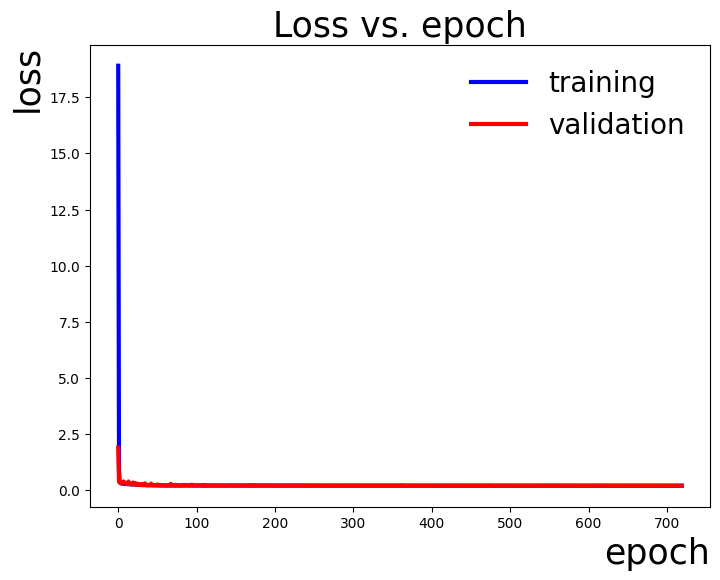

In [26]:
# plot loss function

fig, ax = plt.subplots(1,1, figsize=(8,6))

plt.plot(np.arange(0,epochs_1*iterations), list_loss, label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,epochs_1*iterations), list_val_loss, label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

mean:  [[-0.22783598 -0.26791888 -0.69929856  0.07853756 -1.12725508 -1.19959021]
 [-2.46321416 -0.40669286 -0.82498699 -0.13118272 -0.77905655 -0.25985491]
 [-0.04073563 -0.37999219  0.15124243  0.93414944  0.47049999 -0.29273623]
 ...
 [-0.78889537 -0.61474025  0.49833167 -0.86928314 -0.54783618 -1.6984731 ]
 [ 1.33671892 -1.66489673 -0.01220483 -1.10712075 -0.21395266  0.0627241 ]
 [-1.012128   -1.02559674 -0.03758591  0.37473002  0.09345865 -0.20400567]]
(499889, 6)
std:  [[0.02730815 0.04787143 0.19080916 0.03031308 0.17554222 0.07542685]
 [0.0289276  0.0542889  0.31027102 0.03402011 0.3158434  0.07749108]
 [0.0276672  0.05043005 0.09247462 0.02978291 0.07430467 0.0641656 ]
 ...
 [0.02818207 0.05047767 0.14741383 0.03206321 0.10443284 0.08651128]
 [0.02839462 0.05412157 0.08320723 0.03114286 0.05778443 0.06255292]
 [0.02714831 0.05676642 0.16844399 0.03009543 0.11311494 0.06555524]]


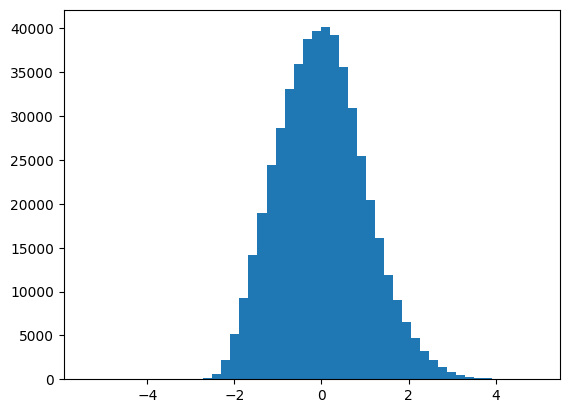

In [13]:
# Read the mean values
filename = 'outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name
means_df = pd.read_csv(filename, sep=' ', header=None)
mean = means_df.values
print("mean: ", mean)
plt.hist(mean[:,5], bins=50)
print(mean.shape)

# Read the std values
filename = 'outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name
stds_df = pd.read_csv(filename, sep=' ', header=None)
std = stds_df.values
print("std: ", std)

z_samples = np.empty([cond_data.shape[0],latent_dim])

In [46]:
cond_data.shape

(878648,)

In [14]:
l=0
for i in range(0,cond_data.shape[0]):
    for j in range(0,latent_dim):
        z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
    
new_events = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])

#reverse min-max normalization
#new_events = rev_minmax_data(new_events, data_min, data_max)

# for i in range(0,new_events.shape[1]):
#     new_events[:,i]=new_events[:,i]*feature_max[i]

os.system("mkdir -p ./outputs/gen_dataset/%s/"%folder_name)
np.savetxt('outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.csv'%folder_name, new_events)

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [15]:
print(z_samples.shape)
print(np.reshape(cond_data, [-1, 1]).shape)

(878648, 6)
(878648, 1)


0.006181785227495769 1.0033299965067901


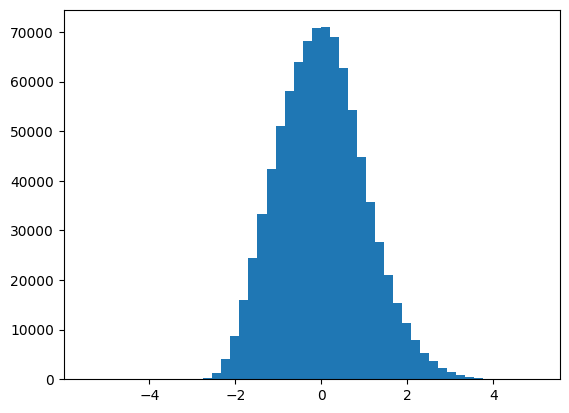

In [28]:
idx = 5 
plt.hist(z_samples[:, idx], bins=50)
print(np.mean(z_samples[:, idx]), np.std(z_samples[:, idx]))

In [17]:
file_gen_SB = 'outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.csv'%folder_name
gen_SB = pd.read_csv(file_gen_SB, delimiter = ' ', header=None, index_col=False)
gen_SB = gen_SB.to_numpy()
print("shape of gen_SR: ", gen_SB.shape)


shape of gen_SR:  (878648, 6)


In [21]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real(gen_data,real_data,doLog,names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="MC Bkg", density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Generated Bkg %s"%names[i], density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        plt.ylim(0,ymax_b*1.5)
#     plt.savefig("fake_gen_compare_cbvae_6var_dynamicbeta.png")

In [19]:
cond_data.shape

(878648,)

/tmp/ipykernel_117021/2461113566.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,ymax_b*1.5)


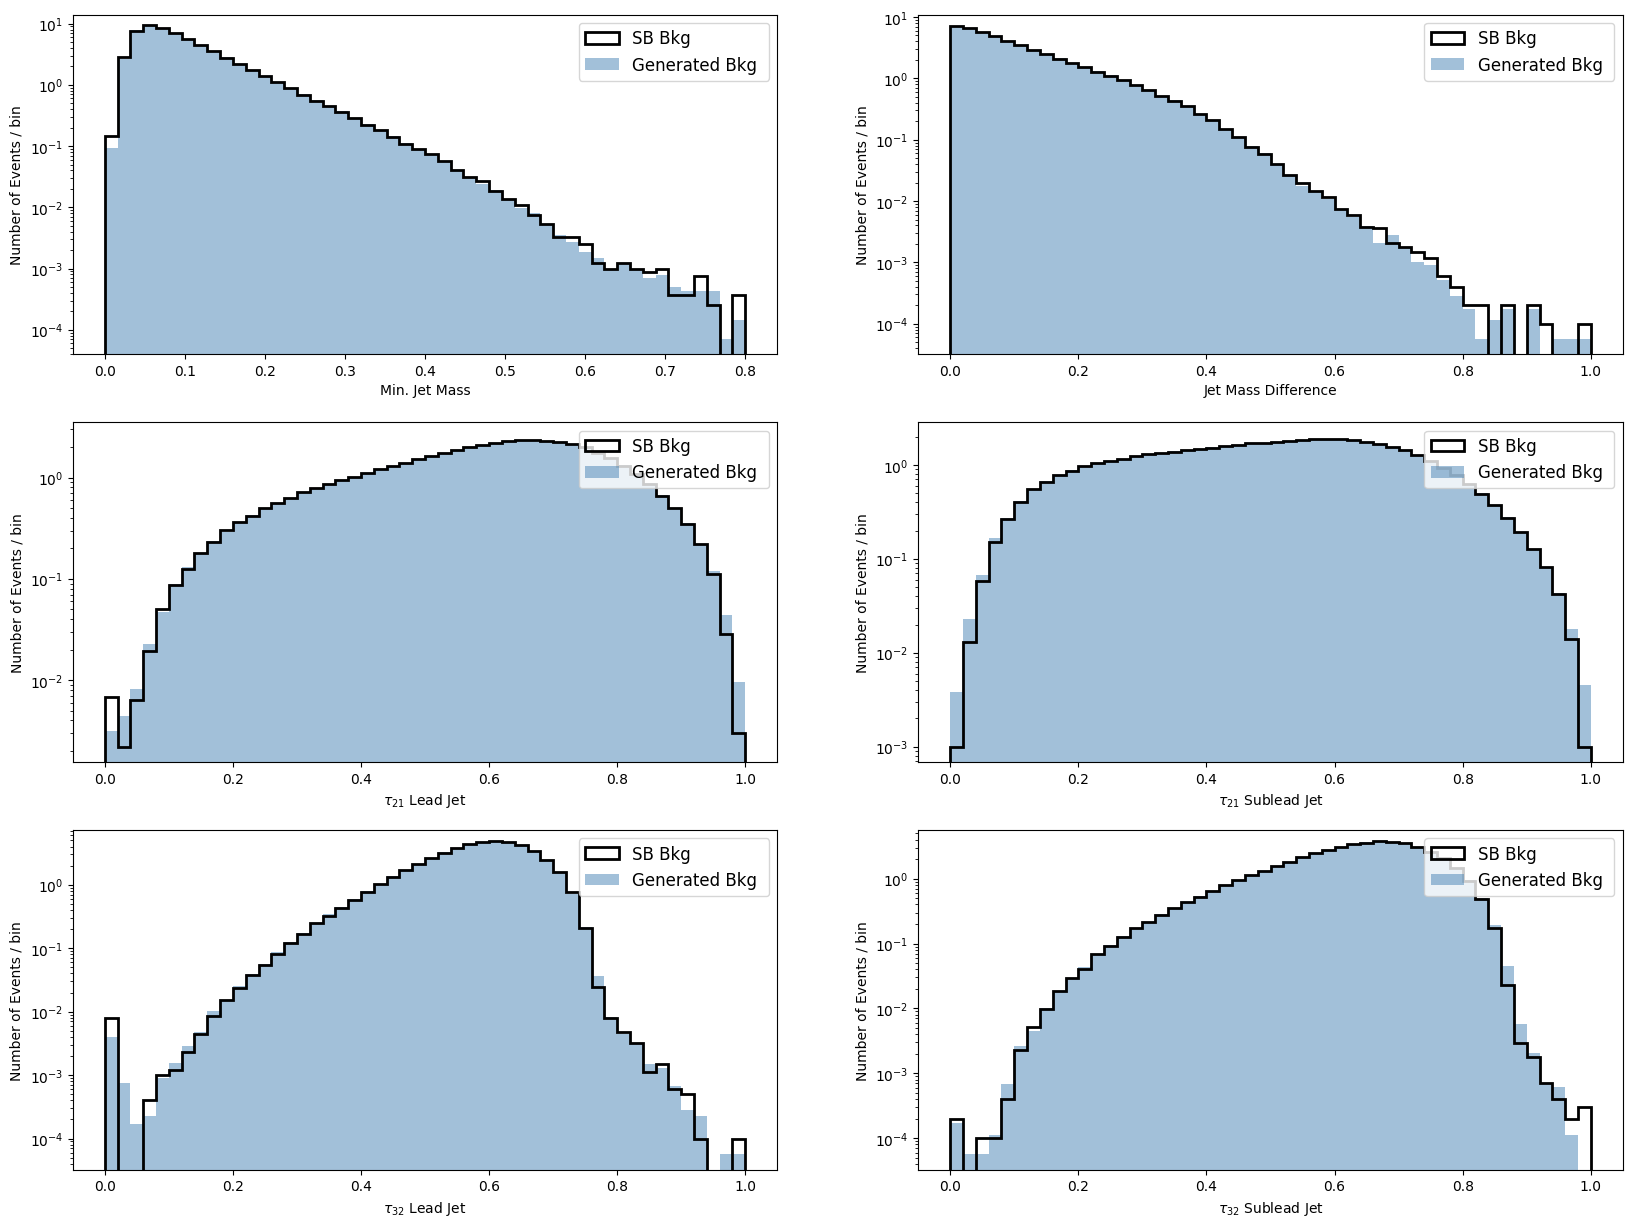

In [20]:
fake_vs_real([gen_SB],[x_train],1,[""])

(40000, 8)
(99605, 6)
(99605,)
(99605, 6)
(878648, 6)
(878648, 1)


/tmp/ipykernel_235053/3486223139.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,ymax_b*1.5)


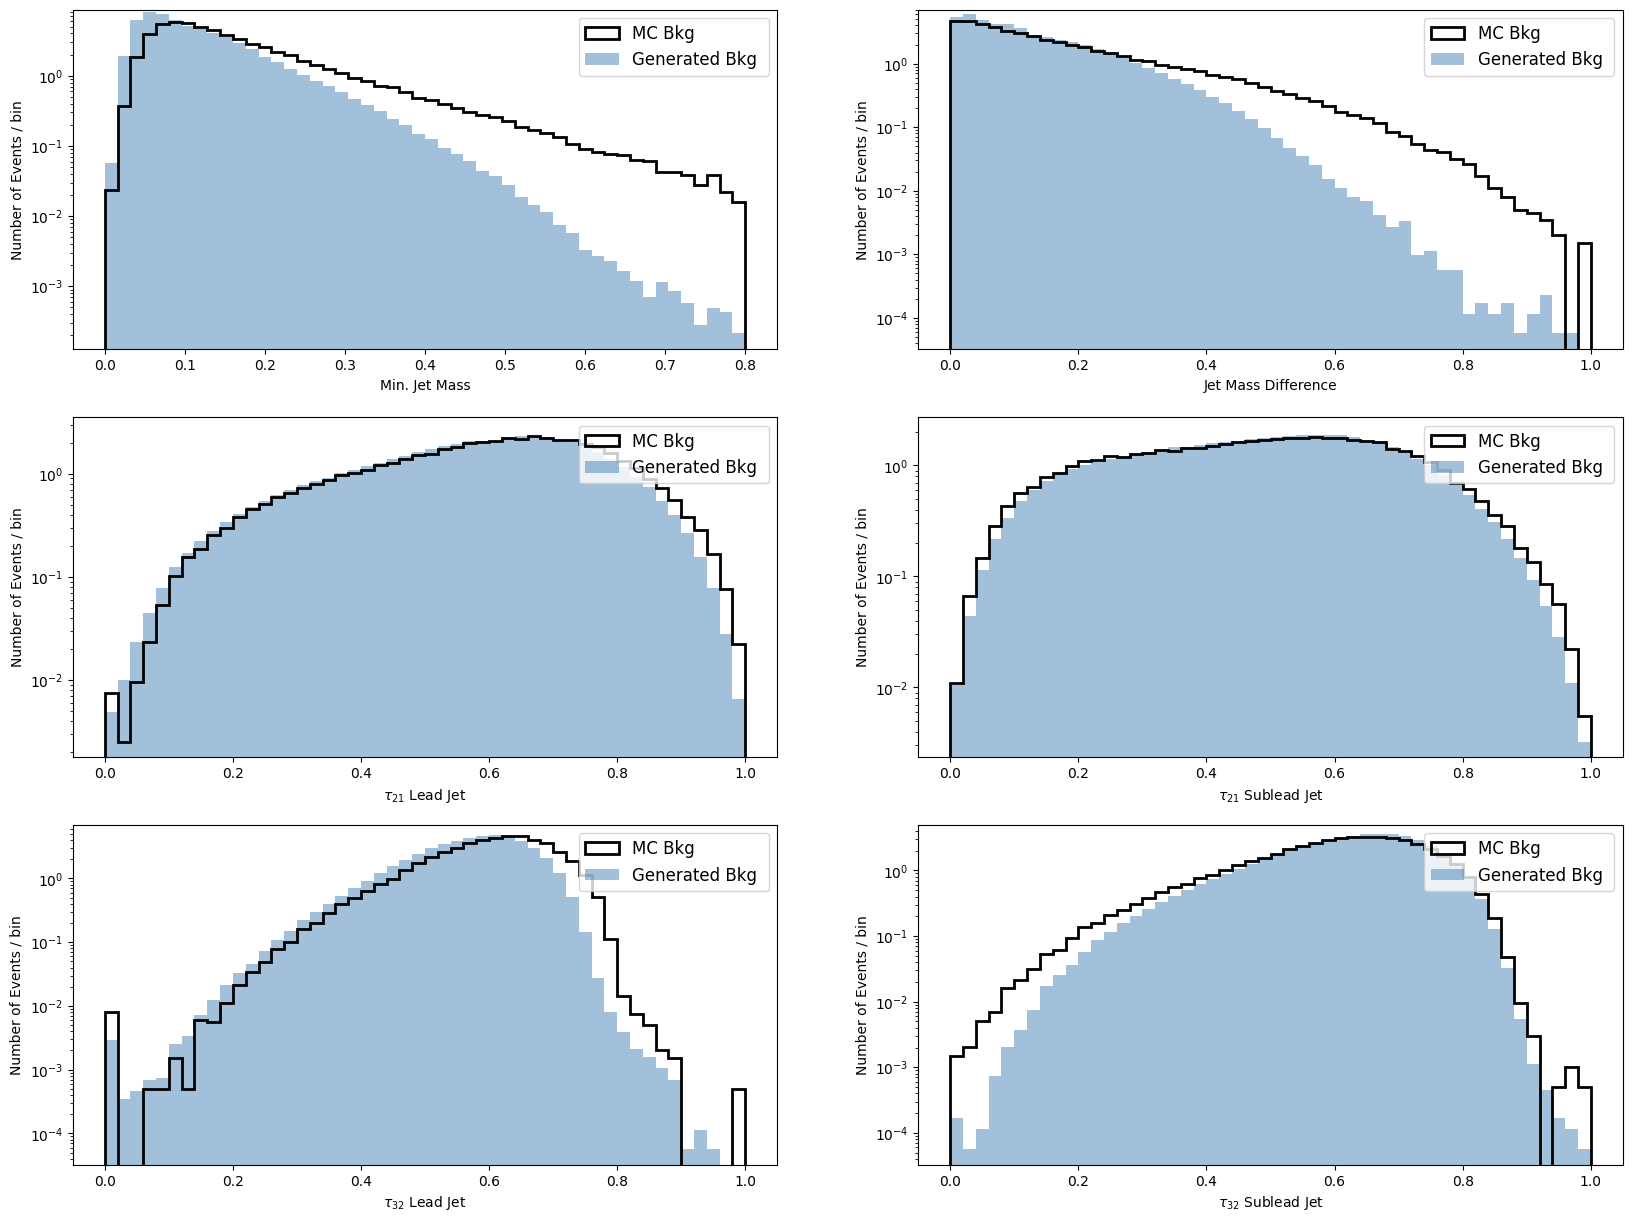

In [26]:
from sklearn.neighbors import KernelDensity

innerdata_train = np.load("./data/preprocessed_data_6var/innerdata_train_6var.npy")
innerdata_test = np.load("./data/preprocessed_data_6var/innerdata_test_6var.npy")

innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
innerdata_test  = innerdata_test[innerdata_test[:,nFeat+1]==0]
print(innerdata_test.shape)

data_sr_train = innerdata_train[:,1:nFeat+1]
data_sr_test = innerdata_test[:,1:nFeat+1]
x_SR = np.concatenate((data_sr_train, data_sr_test), axis=0)
print(x_SR.shape)
x_SR, x_SR_max, x_SR_min = minmax_norm_data(x_SR)


y_innerdata_train = innerdata_train[:,0]
y_innerdata_test = innerdata_test[:,0]
y_SR = np.concatenate((y_innerdata_train, y_innerdata_test), axis=0)
y_SR, cond_data_SR_max, cond_data_SR_min = minmax_norm_cond_data(y_SR)
print(y_SR.shape)

KDE_bandwidth = 0.01
mjj_logit = quick_logit(y_SR)
y_SR = logit_transform_inverse(KernelDensity(
                  bandwidth=KDE_bandwidth, kernel='gaussian').fit(
                  mjj_logit.reshape(-1, 1)).sample(z_samples.shape[0]),
                                                   max(y_SR).item(),
                                                   min(y_SR).item())

x_SR_train = x_SR[:trainsize]
image_size = x_SR_train.shape[1]
original_dim = image_size
x_SR_train = np.reshape(x_SR_train, [-1, original_dim])

print(x_SR_train.shape)
print(z_samples.shape)
print(np.reshape(y_SR, [-1, 1]).shape)

gen_SR = decoder.predict([z_samples, np.reshape(y_SR, [-1, 1])])

fake_vs_real([gen_SR],[x_SR_train],1,[""])